In [1]:
using Printf, Dates, Statistics, DelimitedFiles, StatsBase

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :svg)

# Load Data 

Returns from FX investments (for a US investor) in percent are in `Data_Returns.csv` (extract the returns into a matrix `R`) and log forward premia in percent are in `Data_Forwardpremia.csv` (extract the forward premia into a matrix `fp`). Convert the first columns to Julia dates.

Test if the dates in the two files are the same.

The currency names/abbreviations are
`["AUD","CAD","EUR","JPY","NZD","NOK","SEK","CHF","GBP"]` 

In [3]:
CurrNames = ["AUD","CAD","EUR","JPY","NZD","NOK","SEK","CHF","GBP"]

x  = readdlm("Data_Returns.csv",',',skipstart=1)        #return data
dN = Date.(x[:,1])             #covert to Julia date, eg. 2001-12-31
R  = Float64.(x[:,2:end])

x   = readdlm("Data_Forwardpremia.csv",',',skipstart=2)    #forward premia, skip 2 rows
dN2 = Date.(x[:,1])          
fp  = Float64.(x[:,2:end])

(T,n) = size(R)               #number of data points, number of currencies

(300, 9)

In [4]:
println("Same dates? ",dN == dN2)

Same dates? true


# Plot the forward premia

against time. Create a figure with 3x3 subplots. In the plot show the forward premia multiplied by 12 so they can be interpreted as the (annualised) interest rate differential (foreign minus US). 

Make sure to 
1. have tick marks on the x-axis at `[Date(2000),Date(2010),Date(2020)]`

2. limit the y-axis to `(-6,6)`

3. Put the currency name/abbreviation in the title of each subfigure.

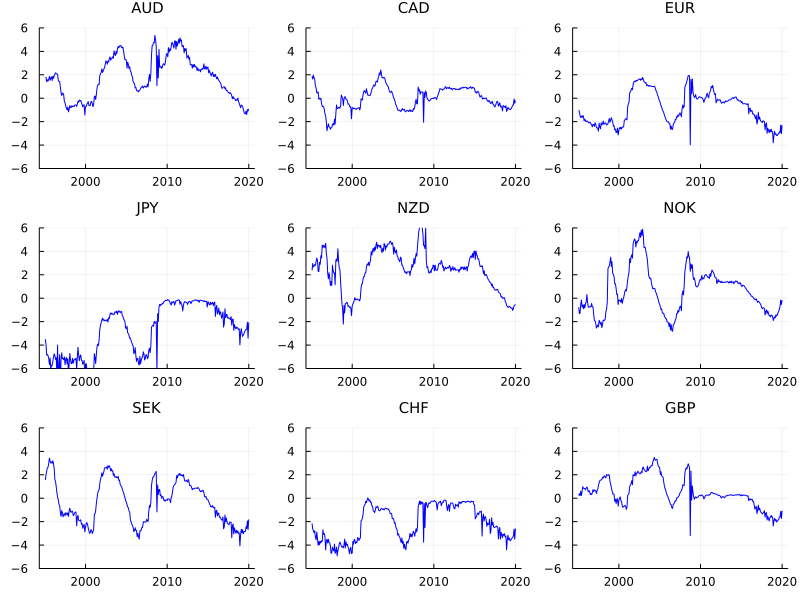

In [5]:
xTicksLoc = [Date(2000),Date(2010),Date(2020)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN,fp*12,
           layout = (3,3),
           legend = false,
           size = (800,600),
           linecolor = :blue,
           xticks = (xTicksLoc,xTicksLab),
           ylims = (-6,6),
           title = reshape(CurrNames,1,:),
           titlefont = font(10) )
display(p1)

# Plot cumulated log returns

in a 3x3 figure (similar to before). The cumulated log returns for a given currency are $r_1,r_1+r_2,r_1+r_2+r_3,...$ etc where $r_t$ is the log return in period $t$.

Make sure to
1. use the same tick marks on the x-axis as before
2. limit the y-axis to (-1,1)

Hints:
1. log returns are $r= \ln(1+R/100)$ since the returns in `R` are in percent. In Julia, use `log()` for the natural logarithm.
2. cumulate using `cumsum()` or by a loop so you get a $T \times 9$ matrix.

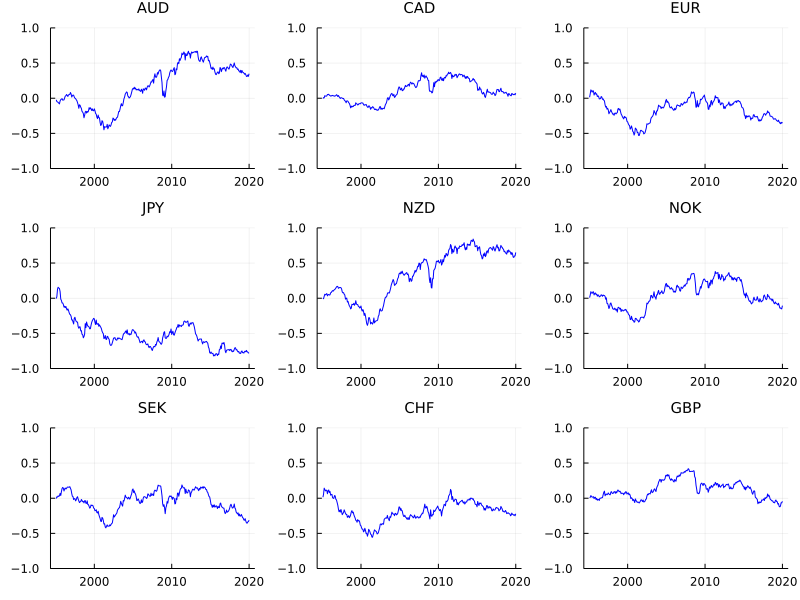

In [6]:
r = log.(1.0.+R/100)
P = cumsum(r,dims=1)

p1 = plot( dN,P,
           layout = (3,3),
           legend = false,
           size = (800,600),
           linecolor = :blue,
           xticks = (xTicksLoc,xTicksLab),
           ylims = (-1,1),
           title = reshape(CurrNames,1,:),
           titlefont = font(10) )
display(p1)

# Implement a carry trade strategy


1. Find the 4 currencies with the highest forward premia (interest rate differential) in $t-1$ and give each a portfolio weight `w[t,i]=1/4`. These are the investment currencies.

2. Find the 4 currencies with the lowest forward premia in $t-1$ and give each a portfolio weight `w[t,i]=-1/4`. These are the funding currencies.

3. The portfolio return in t is `w[t,:]'*R[t,:]`. For all periods that lacks data, set the portfolio return to 0.

4. Create log returns, cumulate and plot (as above).

5. In the plot, add a comparison with an equally weighted portfolio (1/9 in each currency). 

In [7]:
m = 4                #number of long/short positions 

(R_CT,w_CT) = (zeros(T),zeros(T,n))
for t = 2:T         #loop over periods, save portfolio returns
    #local v,wt       #local/global is needed in script
    v                  = sortperm(fp[t-1,:])
    w                  = zeros(n)
    w[v[1:m]]         .= -1/m                 #low interest rate currencies
    w[v[end-m+1:end]] .= 1/m                  #high interest rate currencies 
    R_CT[t]            = w'R[t,:]
    w_CT[t,:]          = w    
end

R_EW = vec(mean(R,dims=2));                   #equally weighted portfolio

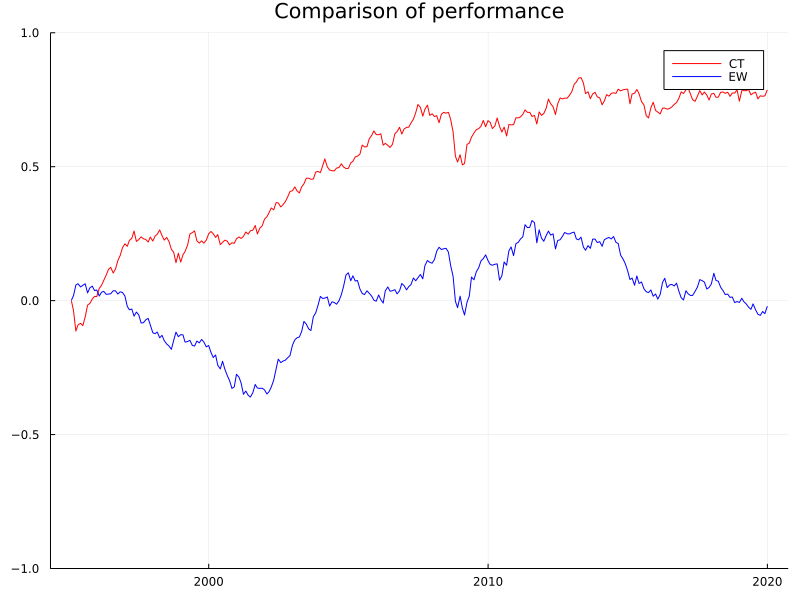

In [8]:
P_CT = cumsum(log.(1.0.+R_CT/100))
P_EW = cumsum(log.(1.0.+R_EW/100));

p1 = plot( dN,[P_CT P_EW],
           label = ["CT" "EW"],
           size = (800,600),
           linecolor = [:red :blue],
           xticks = (xTicksLoc,xTicksLab),
           ylims = (-1,1),
           title = "Comparison of performance")
display(p1)

# Report some return statistics

1. For each of the two portfolio returns, report the average returns, standard deviation and their ratio (the "Sharpe ratio").

2. For each currency, report the frequency of periods that the currency is in the "high" carry trade portfolio.

In [9]:
μ = mean([R_CT R_EW],dims=1)
σ = std([R_CT R_EW],dims=1)
SR = μ./σ

printmat([μ;σ;SR],colNames=["CT","EW"],rowNames=["mean","std","SR"])

println("and in case you want annualised numbers...")
(μ_a,σ_a,SR_a) = (μ*12,σ*sqrt(12),SR*sqrt(12))
printmat([μ_a;σ_a;SR_a],colNames=["CT","EW"],rowNames=["mean","std","SR"])

            CT        EW
mean     0.283     0.018
std      2.038     2.255
SR       0.139     0.008

and in case you want annualised numbers...
            CT        EW
mean     3.401     0.221
std      7.061     7.813
SR       0.482     0.028



In [10]:
println("...and for log returns, in %")

μ = mean(log.(1.0.+[R_CT R_EW]/100),dims=1)*100
σ = std(log.(1.0.+[R_CT R_EW]/100),dims=1)*100
SR = μ./σ

printmat([μ;σ;SR],colNames=["CT","EW"],rowNames=["mean","std","SR"])

println("and in case you want annualised numbers...")
(μ_a,σ_a,SR_a) = (μ*12,σ*sqrt(12),SR*sqrt(12))
printmat([μ_a;σ_a;SR_a],colNames=["CT","EW"],rowNames=["mean","std","SR"])

...and for log returns, in %
            CT        EW
mean     0.262    -0.007
std      2.046     2.256
SR       0.128    -0.003

and in case you want annualised numbers...
            CT        EW
mean     3.147    -0.083
std      7.089     7.816
SR       0.444    -0.011



In [11]:
FreqInHi = mean(0 .< w_CT,dims=1)       #frequence of times the weight is positive

printmat(vec(FreqInHi),rowNames=CurrNames)

AUD     0.983
CAD     0.467
EUR     0.023
JPY     0.000
NZD     0.957
NOK     0.710
SEK     0.317
CHF     0.000
GBP     0.530

